In [1]:
# # This Python 3 environment comes with many helpful analytics libraries installed
# # It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# # For example, here's several helpful packages to load

# import numpy as np # linear algebra
# import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# # Input data files are available in the read-only "../input/" directory
# # For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

# import os
# for dirname, _, filenames in os.walk('/kaggle/input'):
#     for filename in filenames:
#         print(os.path.join(dirname, filename))

# # You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# # You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

In [2]:
# import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import os
import glob
import plotly.graph_objects as go
import cv2
from PIL import Image
from keras.models import Sequential
from keras.layers import Dense
from keras.callbacks import ReduceLROnPlateau, EarlyStopping, ModelCheckpoint

from PIL import ImageFile
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import tensorflow as tf
#from keras.preprocessing.image import ImageDataGenerator
#from keras.utils.np_utils import to_categorical
from tensorflow.keras.preprocessing.image import ImageDataGenerator
#from keras.applications.vgg16 import VGG16
from tensorflow.keras.applications.resnet50 import ResNet50, preprocess_input
from keras.models import Sequential
from keras.layers import Dense, Flatten , Dropout
from keras.optimizers import Adam
from keras.callbacks import EarlyStopping, ReduceLROnPlateau,ModelCheckpoint 
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report
import warnings
warnings.filterwarnings("ignore")
ImageFile.LOAD_TRUNCATED_IMAGES = True

In [3]:
# get the data for training

root_dir = '../input/intel-mobileodt-cervical-cancer-screening'
train_dir = os.path.join(root_dir,'train', 'train')

type1_dir = os.path.join(train_dir, 'Type_1')
type2_dir = os.path.join(train_dir, 'Type_2')
type3_dir = os.path.join(train_dir, 'Type_3')

train_type1_files = glob.glob(type1_dir+'/*.jpg')
train_type2_files = glob.glob(type2_dir+'/*.jpg')
train_type3_files = glob.glob(type3_dir+'/*.jpg')

added_type1_files  =  glob.glob(os.path.join(root_dir, "additional_Type_1_v2", "Type_1")+'/*.jpg')
added_type2_files  =  glob.glob(os.path.join(root_dir, "additional_Type_2_v2", "Type_2")+'/*.jpg')
added_type3_files  =  glob.glob(os.path.join(root_dir, "additional_Type_3_v2", "Type_3")+'/*.jpg')


type1_files = train_type1_files + added_type1_files
type2_files = train_type2_files + added_type2_files
type3_files = train_type3_files + added_type3_files

print(f'''Type 1 files for training: {len(type1_files)} 
Type 2 files for training: {len(type2_files)}
Type 3 files for training: {len(type3_files)}''' )

Type 1 files for training: 1441 
Type 2 files for training: 4348
Type 3 files for training: 2426


In [4]:
# # get data for testing

# test_dir = os.path.join(root_dir,'test', 'test')

# test_files = glob.glob(test_dir+'/*.jpg')

# print(f'''Test files for training: {len(test_files)}''' )

In [5]:
# create dataframe of file and labels
files = {'filepath': type1_files + type2_files + type3_files,
          'label': ['Type 1']* len(type1_files) + ['Type 2']* len(type2_files) + ['Type 3']* len(type3_files)}

files_df = pd.DataFrame(files).sample(frac=1, random_state= 1).reset_index(drop=True)
files_df

,filepath,label
0,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
1,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
2,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
3,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
4,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
...,...,...
8210,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
8211,../input/intel-mobileodt-cervical-cancer-scree...,Type 3
8212,../input/intel-mobileodt-cervical-cancer-scree...,Type 1
8213,../input/intel-mobileodt-cervical-cancer-scree...,Type 2


In [6]:
# describe the dataframe
files_df.describe()

,filepath,label
count,8215,8215
unique,8215,3
top,../input/intel-mobileodt-cervical-cancer-scree...,Type 2
freq,1,4348


In [7]:
# check for duplicates
len(files_df[files_df.duplicated(subset=['filepath'])])

0

In [8]:
# check for damaged files
bad_files = []
for path in (files_df['filepath'].values):
    try:
        img = Image.open(path)
    except:
        index = files_df[files_df['filepath']==path].index.values[0]
        bad_files.append(index)
print(len(bad_files))

3


In [9]:
# # show the bad files
# print(bad_files)

In [10]:
# drop the damaged files
files_df.drop(bad_files, inplace=True)

In [11]:
# check length of files in dataframe
len(files_df)

8212

In [12]:
# check unique labels
files_df['label'].unique()

array(['Type 1', 'Type 3', 'Type 2'], dtype=object)

In [13]:
# get count of each type 
type_count = pd.DataFrame(files_df['label'].value_counts()).rename(columns= {'label': 'Num_Values'})
type_count

,count
label,
Type 2,4346
Type 3,2426
Type 1,1440


In [14]:
# display barplot of type count
#plt.figure(figsize = (15, 6))
#sns.barplot(x= type_count['Num_Values'], y= type_count.index.to_list())
#plt.title('Cervical Cancer Type Distribution')
#plt.grid(True)
#plt.show()

In [15]:
# display pieplot of label distribution
pie_plot = go.Pie(labels= type_count.index.to_list(), values= type_count.values.flatten(),
                 hole= 0.2, text= type_count.index.to_list(), textposition='auto')
fig = go.Figure([pie_plot])
fig.update_layout(title_text='Pie Plot of Type Distribution')
fig.show()

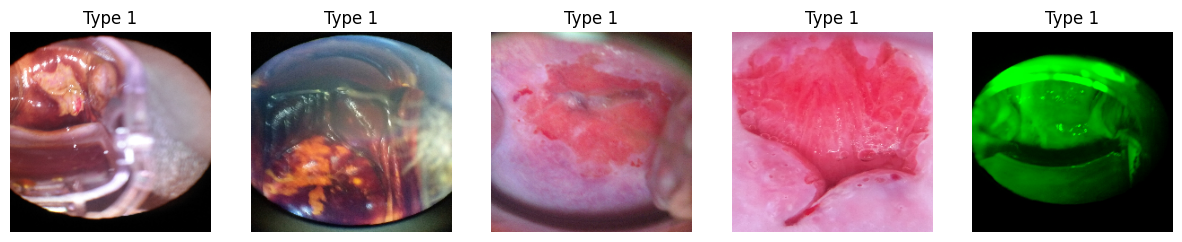

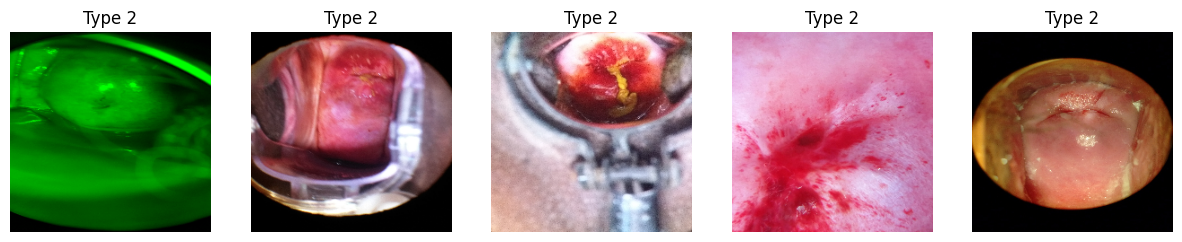

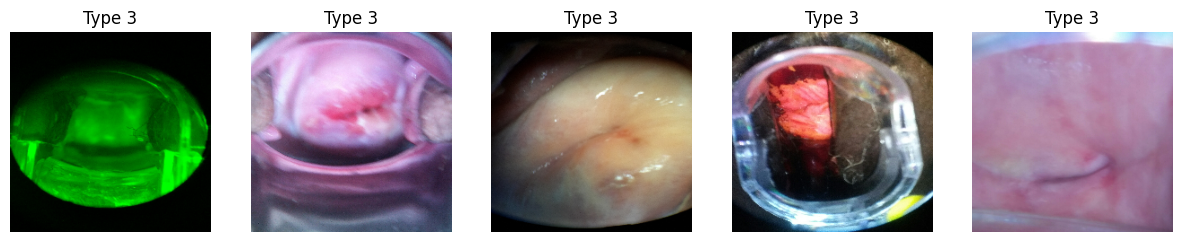

In [16]:
# display sample images of types
for label in ('Type 1', 'Type 2', 'Type 3'):
    filepaths = files_df[files_df['label']==label]['filepath'].values[:5]
    fig = plt.figure(figsize= (15, 6))
    for i, path in enumerate(filepaths):
        img = cv2.imread(path)
        img = cv2.cvtColor(img, cv2.COLOR_RGB2BGR)
        img = cv2.resize(img, (224, 224))
        fig.add_subplot(1, 5, i+1)
        plt.imshow(img)
        plt.subplots_adjust(hspace=0.5)
        plt.axis(False)
        plt.title(label)

# Data Processing

In [17]:
#  split the data into train  and validation set
train_df, eval_df = train_test_split(files_df, test_size= 0.2, stratify= files_df['label'], random_state= 1)
val_df, test_df = train_test_split(eval_df, test_size= 0.5, stratify= eval_df['label'], random_state= 1)
print(len(train_df), len(val_df), len(test_df))

6569 821 822


In [18]:
# loads images from dataframe
def load_images(dataframe):
    features = []
    filepaths = dataframe['filepath'].values
    labels = dataframe['label'].values
    
    for path in filepaths:
        img = cv2.imread(path)
        resized_img = cv2.resize(img, (180, 180))
        features.append(np.array(resized_img))
    return np.array(features), np.array(labels)

In [19]:
# load training and evaluation data
train_features, train_labels = load_images(train_df)
val_features, val_labels = load_images(val_df)
test_features, test_labels = load_images(test_df)

Premature end of JPEG file
Premature end of JPEG file
Premature end of JPEG file


In [20]:
# check lengths of training and evaluation  sets
len(train_features), len(train_labels), len(test_features), len(test_labels), len(test_features), len(test_labels) 

(6569, 6569, 822, 822, 822, 822)

In [21]:
# get image shape
InputShape = train_features[0].shape
print(InputShape)

(180, 180, 3)


In [22]:
# normalize the features
X_train = train_features/255
X_val  = val_features/255
X_test  = test_features/255

In [23]:
from tensorflow.keras.utils import to_categorical
# Fit label encoder
le = LabelEncoder().fit(['Type 1', 'Type 2', 'Type 3'])
# Convert labels to integer encoding first, then to one-hot encoding
y_train = to_categorical(le.transform(train_labels), num_classes=3)
y_val = to_categorical(le.transform(val_labels), num_classes=3)
y_test = to_categorical(le.transform(test_labels), num_classes=3)

In [24]:
# check unique labels
np.unique(y_train)

array([0., 1.])

In [25]:
# initialize image data generator for training and evaluation sets
train_datagen = ImageDataGenerator(
                                rotation_range = 40,
                                zoom_range = 0.2,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                horizontal_flip=True,
                                vertical_flip = True)

eval_datagen = ImageDataGenerator()

In [26]:
# apply data augmentation to features
BATCH_SIZE= 256
train_gen = train_datagen.flow(X_train, y_train, batch_size= BATCH_SIZE)
val_gen = eval_datagen.flow(X_val, y_val, batch_size= BATCH_SIZE)
test_gen = eval_datagen.flow(X_test, y_test, batch_size= BATCH_SIZE)

In [27]:
def balance_dataset(X, y, test_size=0.2, random_state=42):
    """
    Balance a dataset by performing data augmentation on the minority classes.
    
    Parameters:
    X (numpy.ndarray): Input data (e.g., images)
    y (numpy.ndarray): Labels for the input data
    test_size (float): Proportion of the dataset to include in the test set
    random_state (int): Seed for the random number generator
    
    Returns:
    X_train, X_val, X_test, y_train, y_val, y_test
    """
    
    # Split the data into train, validation, and test sets
    X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=test_size, stratify=y, random_state=random_state)
    X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, test_size=0.5, stratify=y_test, random_state=random_state)
    # Get the counts of each class in the training set
    class_counts = np.bincount(y_train)
    
    # Create an image data generator for data augmentation
    datagen = ImageDataGenerator(
        rotation_range=20,
        width_shift_range=0.2,
        height_shift_range=0.2,
        shear_range=0.2,
        zoom_range=0.2,
        horizontal_flip=True,
        fill_mode='nearest'
    )
    
    # Balance the dataset by performing data augmentation on the minority classes
    X_train_balanced = X_train.copy()
    y_train_balanced = y_train.copy()
    for class_idx, count in enumerate(class_counts):
        if count < max(class_counts):
            class_mask = (y_train == class_idx)
            X_class = X_train[class_mask]
            y_class = y_train[class_mask]
            
            # Generate additional samples for the minority class
            X_augmented = datagen.flow(X_class, y_class, batch_size=count, shuffle=True).next()[0]
            X_train_balanced = np.concatenate([X_train_balanced, X_augmented], axis=0)
            y_train_balanced = np.concatenate([y_train_balanced, y_class], axis=0)
           
    return X_train_balanced, X_val, X_test, y_train_balanced, y_val, y_test
    

In [28]:
# show shape of each  batch
for data_batch, labels_batch in train_gen:
    print('data batch shape: {} \n labels batch shape: {}'.format(data_batch.shape, labels_batch.shape))
    break

data batch shape: (256, 180, 180, 3) 
 labels batch shape: (256, 3)


In [29]:
# initialize pretrained vgg model base
#conv_base = VGG16(weights= 'imagenet', include_top= False, input_shape= (180, 180, 3))

In [30]:
# #resnet50
# conv_base = ResNet50(weights='imagenet', 
#                      include_top=False, 
#                      input_shape=(180, 180, 3))

In [31]:
# # show trainable layers before freezing
# print('This is the number of trainable weights '
# 'before freezing layers in the conv base:', len(conv_base.trainable_weights))

In [32]:
# # freeze few layers of pretrained model
# for layer in conv_base.layers[:-5]:
#     layer.trainable= False

In [33]:
# # show trainable layers after freezing
# print('This is the number of trainable weights '
# 'after freezing layers in the conv base:', len(conv_base.trainable_weights))

In [40]:
from keras.layers import GlobalAveragePooling2D, Reshape, Dense, multiply

def se_block(in_block, ch, ratio=16):
    # Squeeze: Global Average Pooling
    x = GlobalAveragePooling2D()(in_block)
    x = Reshape((1, 1, ch))(x)

    # Excitation: Fully Connected layers
    x = Dense(ch // ratio, activation='relu')(x)
    x = Dense(ch, activation='sigmoid')(x)

    # Scale: Multiply channel-wise with the original input
    return multiply([in_block, x])  # Corrected to pass inputs directly


In [61]:
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout, BatchNormalization
from keras.regularizers import l2

model = Sequential([
    # 1st Convolutional Layer with Batch Normalization and Dropout
    Conv2D(32, (3, 3), activation='relu', input_shape=(180, 180, 3)),
    #se_block(model.output, 32),
    BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 2nd Convolutional Layer
    Conv2D(64, (3, 3), activation='relu'),
    #BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 3rd Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    #BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.2),

    # 4th Convolutional Layer
    Conv2D(128, (3, 3), activation='relu'),
    #BatchNormalization(),
    MaxPooling2D(pool_size=(2, 2)),
    Dropout(0.25),

    # Flatten the output
    Flatten(),

    # 5th Fully Connected Layer with L2 Regularization
    Dense(256, activation='relu', kernel_regularizer=l2(0.005)),
    Dropout(0.5),

    # 6th Fully Connected Layer
    Dense(128, activation='relu', kernel_regularizer=l2(0.01)),

    # 7th Output Layer
    Dense(3, activation='softmax')
])


In [62]:
# compile model
model.compile(optimizer=Adam(0.0001), loss='categorical_crossentropy',metrics=['accuracy'])

In [63]:
# show model summary
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ conv2d_19 (Conv2D)              │ (None, 178, 178, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ batch_normalization_14          │ (None, 178, 178, 32)   │           128 │
│ (BatchNormalization)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_16 (MaxPooling2D) │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_20 (Dropout)            │ (None, 89, 89, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_20 (Conv2D)              │ (None, 87, 87, 64)     │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_17 (MaxPooling2D) │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 43, 43, 64)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_21 (Conv2D)              │ (None, 41, 41, 128)    │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_18 (MaxPooling2D) │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 20, 20, 128)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_22 (Conv2D)              │ (None, 18, 18, 128)    │       147,584 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_19 (MaxPooling2D) │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 9, 9, 128)      │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 10368)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_24 (Dense)                │ (None, 256)            │     2,654,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_24 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_25 (Dense)                │ (None, 128)            │        32,896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_26 (Dense)                │ (None, 3)              │           387 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,928,707 (11.17 MB)

 Trainable params: 2,928,643 (11.17 MB)

 Non-trainable params: 64 (256.00 B)

In [64]:
# define training steps
TRAIN_STEPS = len(train_df)//BATCH_SIZE
VAL_STEPS = len(val_df)//BATCH_SIZE

In [65]:
# initialize callbacks
reduceLR = ReduceLROnPlateau(monitor='val_loss', patience=10, verbose= 1, mode='min', factor=  0.1, min_lr = 1e-5)

#early_stopping = EarlyStopping(monitor='val_loss', patience = 20, verbose=1, mode='min', restore_best_weights= True)

checkpoint = ModelCheckpoint('cervicalModel.weights.keras', monitor='val_loss', verbose=1, save_best_only=True, mode='min')

In [66]:
# train model
history = model.fit(train_gen, steps_per_epoch= TRAIN_STEPS, validation_data=val_gen, validation_steps=VAL_STEPS, epochs= 120,
                   callbacks= [reduceLR, checkpoint])

Epoch 1/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 2s/step - accuracy: 0.4587 - loss: 5.2669
Epoch 1: val_loss improved from inf to 5.04508, saving model to cervicalModel.weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 62s 2s/step - accuracy: 0.4599 - loss: 5.2624 - val_accuracy: 0.5273 - val_loss: 5.0451 - learning_rate: 1.0000e-04
Epoch 2/120
 1/25 ━━━━━━━━━━━━━━━━━━━━ 5s 235ms/step - accuracy: 0.5430 - loss: 4.9270
Epoch 2: val_loss improved from 5.04508 to 5.02964, saving model to cervicalModel.weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 1s 24ms/step - accuracy: 0.5430 - loss: 4.9270 - val_accuracy: 0.5660 - val_loss: 5.0296 - learning_rate: 1.0000e-04
Epoch 3/120
25/25 ━━━━━━━━━━━━━━━━━━━━ 0s 1s/step - accuracy: 0.5090 - loss: 4.9144
Epoch 3: val_loss improved from 5.02964 to 4.76967, saving model to cervicalModel.weights.keras
25/25 ━━━━━━━━━━━━━━━━━━━━ 47s 1s/step - accuracy: 0.5094 - loss: 4.9116 - val_accuracy: 0.5391 - val_loss: 4.7697 - learning_rate: 1.0000e-04
Epoch 4/120
 1/25 ━━━━━━━━━━━━━

In [67]:
# read training history into dataframe
history_df = pd.DataFrame(history.history)

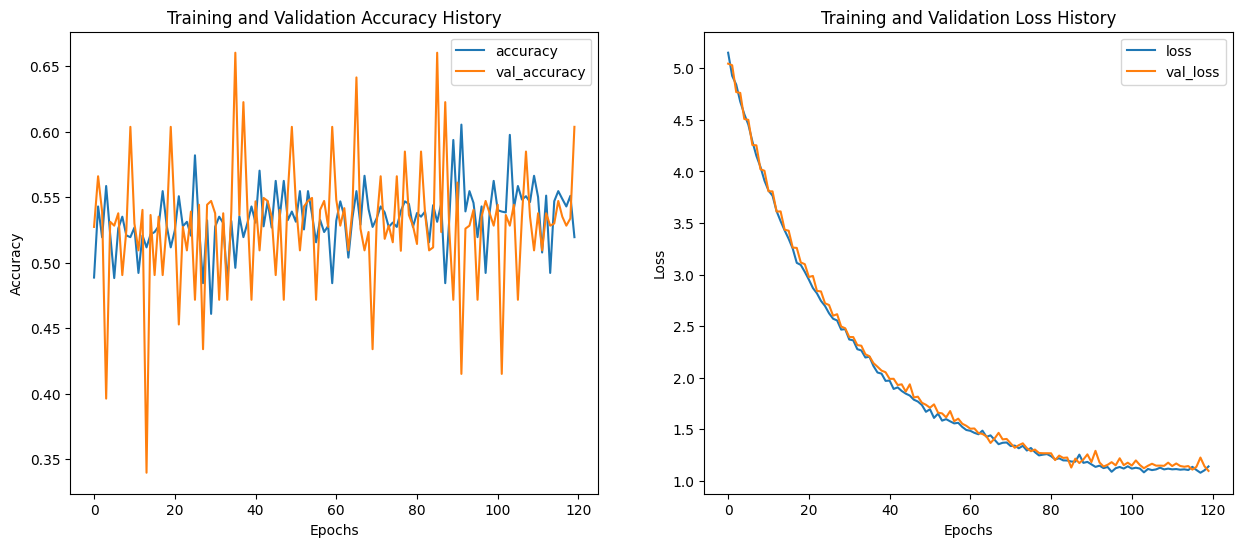

In [68]:
# display training and validation history

# display history of accurracy
plt.figure(figsize= (15,6))
plt.subplot(1,2,1)
plt.plot(history_df['accuracy'], label= 'accuracy' )
plt.plot(history_df['val_accuracy'], label= 'val_accuracy')
# history_df[['acc', 'val_acc']]
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.title('Training and Validation Accuracy History')
plt.legend()

# display history of loss
plt.subplot(1,2,2)
plt.plot(history_df['loss'], label= 'loss')
plt.plot(history_df['val_loss'], label= 'val_loss')
# history_df[['loss', 'val_loss']].plot()
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training and Validation Loss History')
plt.legend()

plt.show()

In [ ]:
# load best weights into model
model.load_weights('cervicalModel.weights.keras')

In [ ]:
# save model
model.save('cancer_screen_model.h5')

In [ ]:
# evaluate model on test set
model.evaluate(test_gen)

In [ ]:
# with open('cancer.pickle', 'wb') as f:
#     pickle.dump(model, f)

In [ ]:
# get test data directory
test_dir = os.path.join(root_dir,'test', 'test')

In [ ]:
# load test features and labels
test_filenames = []
test_features = []
for filename in os.listdir(test_dir):
    test_filenames.append(filename)
    filepath = os.path.join(test_dir, filename)
    img = cv2.imread(filepath)
    resized_img = cv2.resize(img, (180, 180))
    test_features.append(np.array(resized_img)) 

In [ ]:
# show length of test features and labels
print(len(test_filenames), len(test_features))

In [ ]:
# normalize test features
test_X = np.array(test_features)
test_X = test_X/255

In [ ]:
# get test predictions
test_predict = model.predict(test_X)
test_predict[0]

In [ ]:
# show encoded classes
le.classes_

In [ ]:
# create dataframe of test predictions
sub_df = pd.DataFrame(test_predict, columns= ['Type 1', 'Type 2', 'Type 3' ])
sub_df['image_name'] = test_filenames
sub_df = sub_df[['image_name', 'Type 1', 'Type 2', 'Type 3']]
sub_df = sub_df.sort_values(['image_name']).reset_index(drop=True)
sub_df.head()